# ACT validation

In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)

sys.path.insert(1, '/home/jaimerz/PhD/xCell')


from xcell.mappers import MapperBOSS
from xcell.mappers import MapperACTDR4Lensing
from xcell.mappers import MapperACTDR4tSZ
from xcell.mappers import utils
from astropy.io import fits
from astropy.table import Table
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import numpy as np
import os

In [2]:
def compute_cl(mapper_a, mapper_b, bands, wsp_file):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    n_a = mapper_a.mask_power
    n_b = mapper_b.mask_power
    f_a = mapper_a.get_nmt_field()
    f_b = mapper_b.get_nmt_field()
    w_a = mapper_a.get_mask()
    w_b = mapper_b.get_mask()
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    if os.path.isfile(wsp_file):
        wsp.read_from(wsp_file)
    else:
        wsp = nmt.NmtWorkspace()
        wsp.write_to(wsp_file)
    wsp.compute_coupling_matrix(f_a, f_b, bands)
    
    if (n_a > 1) or (n_b > 1):
        cl_coupled *= np.mean(w_a**(n_a-1))*np.mean(w_b**(n_b-1))
        cl_coupled *= np.mean(w_a*w_b)/np.mean(w_a**n_a*w_b**n_b)   
    
    cl_decoupled = wsp.decouple_cell(cl_coupled)

    return cl_coupled, cl_decoupled

# Configs

In [3]:
nside = 2048
path_ACT = '/home/jaimerz/PhD/xCell/data/ACT/'
ACTk_config = {'file_map':path_ACT+'act_planck_dr4.01_s14s15_D56_lensing_kappa_baseline.fits',
               'file_mask':path_ACT+'act_dr4.01_s14s15_D56_lensing_mask.fits',
               'mask_name': 'mask_CMBK',
               'nside': nside, 
               'mask_power': 1}
ACTtSZ_config = {'file_map':path_ACT+'tilec_single_tile_D56_comptony_map_v1.2.0_joint.fits',
                 'file_noise': path_ACT+'tilec_single_tile_D56_comptony_map_v1.2.0_joint_noise.fits',
                 'file_beam': path_ACT+'tilec_single_tile_D56_comptony_map_v1.2.0_joint_beam,.fits',
               'file_mask': path_ACT+'masks/compsep_masks/act_dr4.01_s14s15_D56_compsep_mask.fits',
               'mask_name': 'mask_CMBtSZ',
               'nside': nside}
path_BOSS = '/home/jaimerz/PhD/xCell/data/BOSS/'
BOSS_config = {'data_catalogs': [path_BOSS+'galaxy_DR12v5_CMASSLOWZTOT_South.fits'], 
               'random_catalogs':[path_BOSS+'random0_DR12v5_CMASSLOWZTOT_South.fits'],
               #'file_mask': [path_ACT+'act_dr4.01_s14s15_D56_lensing_mask.fits'],
               'file_mask': [path_BOSS+'mask_DR12v5_CMASSLOWZTOT_South.fits'], 
               'SDSS_name': 'BOSS',
               'mask_name': 'mask_BOSS', 
               'nside': nside}

In [4]:
#ells = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 272, 309,
#        351, 398, 452, 513, 582, 661, 750, 852,  967, 1098, 1247, 1416, 1536, 1608, 1826, 2073, 2354, 2673, 3072])
ells = []
i = 11.5
while i <= 3*nside: #l[-1]:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+40*(1+i/500)
bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

# ACTk X BOSS

In [5]:
ACTk_mapper = MapperACTDR4Lensing(ACTk_config)
BOSS_mapper_wrong = MapperBOSS(BOSS_config)
BOSS_mapper = MapperBOSS(BOSS_config)

In [6]:
BOSS_wrong_signal = np.load('/home/jaimerz/PhD/xCell/data/BOSS/Wrong_CMASS_delta.npz')['signal_map']

In [7]:
ACTk_signal = ACTk_mapper.get_signal_map()
ACTk_mask = ACTk_mapper.get_mask()

BOSS_mapper_wrong.delta_map = BOSS_wrong_signal[0]
BOSS_signal_wrong = BOSS_mapper_wrong.get_signal_map()
BOSS_mapper_wrong.mask = ACTk_mask
BOSS_mask_wrong = BOSS_mapper_wrong.get_mask()

BOSS_signal = BOSS_mapper.get_signal_map()
BOSS_mask = BOSS_mapper.get_mask()

/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


## Plots

/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a reg

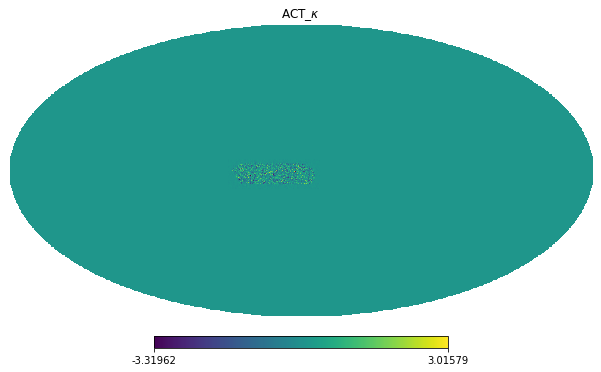

In [8]:
hp.visufunc.mollview(ACTk_signal[0], title= r'ACT_$\kappa$')

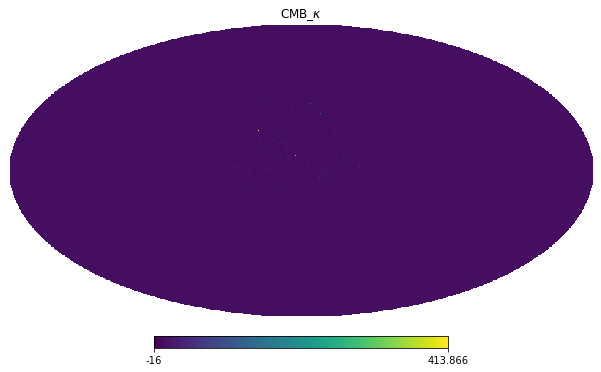

In [9]:
hp.visufunc.mollview(BOSS_signal[0], title= r'CMB_$\kappa$')

In [10]:
ref = np.load('/home/jaimerz/PhD/xCell/data/ACT/ACTk_BOSS_cl.npz')

## Cls

### Calculation with anafast

In [11]:
cosmo = ccl.boltzmann.classy.Class()
params = {'h': 0.67,
'Omega_cdm': 0.25, #0.237153,
'Omega_b': 0.05,
'n_s': 0.9649,
'ln10^{10}A_s': 3.045}
cosmo.set(params)
cosmo.compute()
z_arr = np.arange(0, 1.1, 0.1)
b_arr = 2.00 *np.ones(len(z_arr))
X_arr = [cosmo.angular_distance(z)*(1+z) for z in z_arr]
dNdz = np.sin(z_arr*np.pi)**2
nz = [list(z_arr), list(dNdz)]
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
clustering_t = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_arr, dNdz), bias=(z_arr, b_arr))
lensing_t = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, dNdz))
CMBlensing_t = ccl.CMBLensingTracer(cosmo, 1100)

#np.savetxt('/home/jaimerz/PhD/LimberJack.jl/nz.txt', nz)
#np.savetxt('/home/jaimerz/PhD/LimberJack.jl/bg.txt', b_arr)
#np.savetxt('/home/jaimerz/PhD/LimberJack.jl/clustering_tracer.txt', clustering_t.get_kernel(X_arr))
#np.savetxt('/home/jaimerz/PhD/LimberJack.jl/lensing_tracer.txt', lensing_t.get_kernel(X_arr))
#np.savetxt('/home/jaimerz/PhD/LimberJack.jl/CMBlensing_tracer.txt', CMBlensing_t.get_kernel(X_arr))

In [12]:
b_BOSS = 2.00 *np.ones(50)
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
BOSS_nz = BOSS_mapper.get_nz()
BOSS_z = BOSS_nz[0]
BOSS_dNdz = BOSS_nz[1]
np.savetxt('/home/jaimerz/PhD/LimberJack.jl/BOSS_nz.txt', BOSS_nz)
np.savetxt('/home/jaimerz/PhD/LimberJack.jl/BOSS_bg.txt', b_BOSS)

BOSS_t = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(BOSS_z, BOSS_dNdz), bias=(BOSS_z, b_BOSS))
ACTk_t = ccl.CMBLensingTracer(cosmo, 1100)
ACTk_BOSS_cl_t = ccl.angular_cl(cosmo, ACTk_t, BOSS_t, ell_arr) 
ACTk_ACTk_cl_t = ccl.angular_cl(cosmo, ACTk_t, BOSS_t, ell_arr) 
BOSS_BOSS_cl_t = ccl.angular_cl(cosmo, ACTk_t, BOSS_t, ell_arr) 

In [13]:
ACTk_signal_w = ACTk_signal[0]*np.mean(ACTk_mapper.pixell_mask**2) 
cl  = hp.anafast(BOSS_signal_wrong[0]*BOSS_mask_wrong, ACTk_signal_w*ACTk_mask)
cl /= np.mean(BOSS_mask_wrong**2*ACTk_mask**2)
ell = np.arange(len(cl))
print(ell.max())
# Bin the resulting spectra as well as the ell values
bins      = np.linspace(50, 3000, 20)
digitized = np.digitize(ell, bins)
cl_binned  = [cl[digitized == i].mean() for i in range(1, len(bins))]
ell_binned = [ell[digitized == i].mean() for i in range(1, len(bins))]

ValueError: operands could not be broadcast together with shapes (12582912,) (50331648,) 

In [ ]:
# Now plot the quick powerspectrum we just made
plt.figure(figsize = (8,6))
plt.rc('font', family='serif')
plt.plot(ell_binned, cl_binned, 'r-', label='Anafast Cl')
plt.plot(ref['ell'], ref['cl'] , 'b--', label='Reference')
plt.plot(ell_arr, ACTk_BOSS_cl_t , 'k--', label='Theory')
plt.xlabel('L')
plt.ylabel('$C_{L}$')
plt.xlim(100, 3000)
plt.title("CMASS Galaxies x ACT Lensing Map", fontsize = 20)
plt.loglog()
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

### CCL calculation 

In [ ]:
#ACTk_mapper.signal_map = ACTk_mapper.signal_map/np.mean(ACTk_mapper.pixell_mask**2)

In [ ]:
mod = np.mean(ACTk_mapper.pixell_mask**2)*np.mean(ACTk_mapper.mask*BOSS_mapper.mask)
#mod = np.mean(ACTk_mapper.mask**2)*np.mean(ACTk_mapper.mask*BOSS_mapper.mask)
mod /= np.mean(ACTk_mapper.mask**3*BOSS_mapper.mask)
mod

In [ ]:
cl_ACTk_BOSS, cl_ACTk_BOSS_dc = compute_cl(ACTk_mapper, BOSS_mapper, bands, 'wsp_ACTk_BOSS.fits')

In [ ]:
plt.plot(ell_arr, cl_ACTk_BOSS_dc[0], 'r-', label='MCM*Pcl')
plt.plot(ell_arr, mod*cl_ACTk_BOSS_dc[0] , 'g-', label='MCM*Pcl*mod')
plt.plot(ell_arr, ACTk_BOSS_cl_t , 'r--', label='Theory')
plt.plot(ref['ell'], ref['cl'] , 'b--', label='Reference')
plt.loglog()
plt.title('BOSS-ACTk')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

# ACT tSZ

In [14]:
ACTtSZ_mapper = MapperACTDR4tSZ(ACTtSZ_config)

In [17]:
fits.open(path_ACT+'tilec_single_tile_D56_comptony_map_v1.2.0_joint_noise.fits')

OSError: Empty or corrupt FITS file

In [15]:
ACTtSZ_signal = ACTtSZ_mapper.get_signal_map() 
ACTtSZ_mask = ACTtSZ_mapper.get_mask()
ACTtSZ_noise = ACTtSZ_mapper.get_noise()

/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/jaimerz/.local/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


OSError: Empty or corrupt FITS file

## Plots

In [ ]:
hp.visufunc.mollview(ACTtSZ_signal[0], title= r'ACT_tSZ')

In [ ]:
hp.visufunc.mollview(ACTtSZ_mask, title= r'ACT_tSZ')

In [ ]:
hp.visufunc.mollview(ACTtSZ_noise, title= r'ACT_tSZ')

## Cls

In [ ]:
tSZ_nl = ACTtSZ_mapper.get_nl_coupled()

In [ ]:
tSZ_cl, tSZ_cl_dc = compute_cl(ACTtSZ_mapper, ACTtSZ_mapper, bands, 'wsp_ACTk_BOSS.fits')
tSZ_dl_dc = ell_arr**2*tSZ_cl/(2*np.pi)

In [ ]:
plt.plot(ell_arr, tSZ_cl[0], 'r-', label='cl')
plt.loglog()
plt.title('ACTtSZ ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
plt.plot(ell_arr, tSZ_dl[0], 'r-', label='dl')
plt.yscale('log')
plt.title('ACTtSZ ')
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$D_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()